# Assignment 3 - COSC102 - T2 - 2023

## Authors:
- Lucas Fonseca Martins
- 
- 



In [71]:
# Import the libraries
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from dtreeviz.trees import *

In [72]:
# Defines
imu_data_file = 'a3_imu_data.csv'
activity_annotations_data_file = 'a3_activity_annotations.csv'
video_length = 712 # seconds

In [73]:
# Set the lists to store the IMU data

time_track = []
ax_set = []
ay_set = []
az_set = []

gx_set = []
gy_set = []
gz_set = []

activity_set = []

In [91]:
activity_mapping = {
        'Standing': 0,
        'Walking': 1,
        'Jogging': 2,
        'Side-Step': 3,
        'Running': 4
    }

def map_activity(activity_string):
    """
    Maps a given activity string to a corresponding integer value.

    The following mappings are used:
        'Standing'   -> 0
        'Walking'    -> 1
        'Jogging'    -> 2
        'Side-Step'  -> 3
        'Running'    -> 4

    :param activity_string: A string representing the activity.
    :return: An integer corresponding to the given activity, or None if the activity string is not recognized.
    """
    return activity_mapping.get(activity_string, None)

def get_activity_list():
    """
    Returns a list of activities in order according to their mapped values.

    :return: A list of activities.
    """
    activity_list = [None] * len(activity_mapping)
    for activity, value in activity_mapping.items():
        activity_list[value] = activity

    return activity_list




In [75]:
# Define the fields/column names
fields = ['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

# Open the CSV file containing the IMU data
with open(imu_data_file, newline='') as f:
    reader = csv.DictReader(f, fieldnames=fields)
    for row in reader:
        #print(row)
        time_track.append(float(row['time']))
        ax_set.append(float(row['ax']))
        ay_set.append(float(row['ay']))
        az_set.append(float(row['az']))
        gx_set.append(float(row['gx']))
        gy_set.append(float(row['gy']))
        gz_set.append(float(row['gz']))

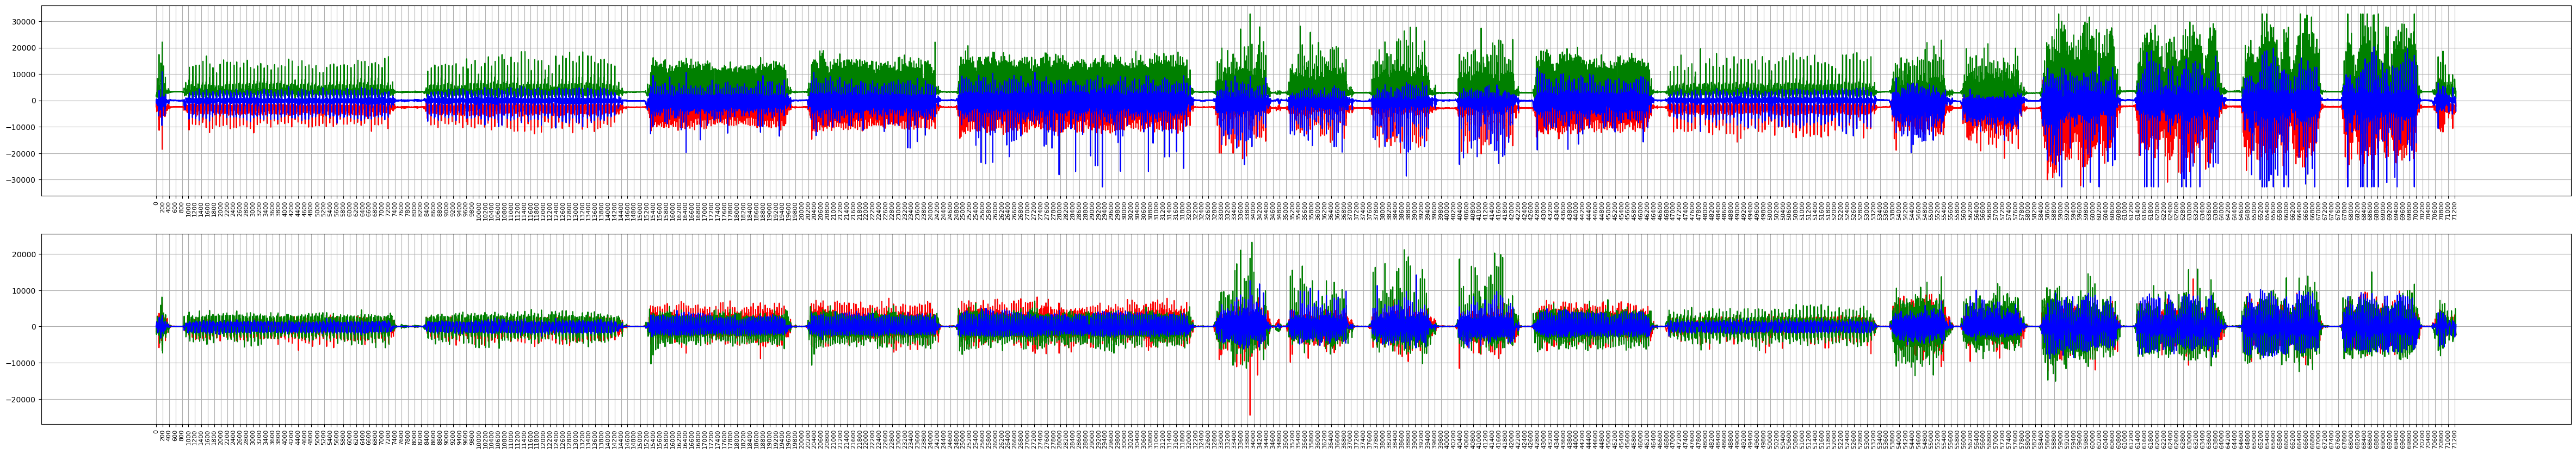

In [76]:
# Visualize the IMU data for sanity check

fig, axs = plt.subplots(2,1,figsize=(60,10))

axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')
axs[0].set_xticks(range(0, len(ax_set), 200)) # Add this line to set ticks at intervals of 100
axs[0].set_xticklabels(axs[0].get_xticks(), rotation=90, fontsize=8) # Rotate the labels by 90 degrees
axs[0].grid(True)  # Add grid to first subplot

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')
axs[1].set_xticks(range(0, len(gx_set), 200)) # Add this line to set ticks at intervals of 100
axs[1].set_xticklabels(axs[1].get_xticks(), rotation=90, fontsize=8) # Rotate the labels by 90 degrees
axs[1].grid(True)  # Add grid to first subplot


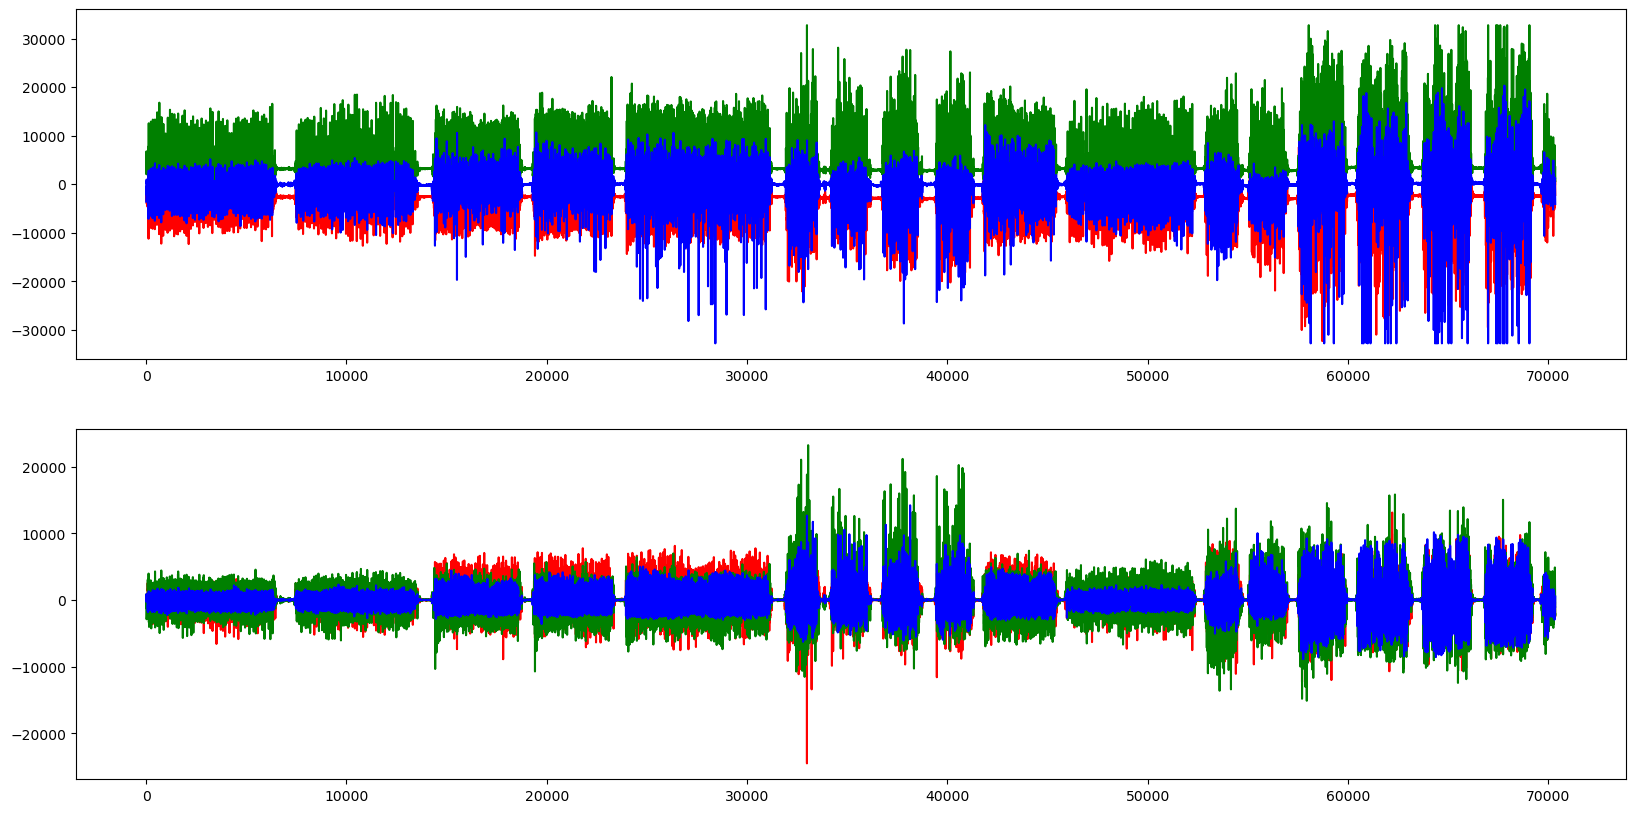

In [77]:
start_idx = 900 # by observation

fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:], color='r')
axs[0].plot(ay_set[start_idx:], color='g')
axs[0].plot(az_set[start_idx:], color='b')

axs[1].plot(gx_set[start_idx:], color='r')
axs[1].plot(gy_set[start_idx:], color='g')
axs[1].plot(gz_set[start_idx:], color='b')

Start Time Stamp: 1598240222.0


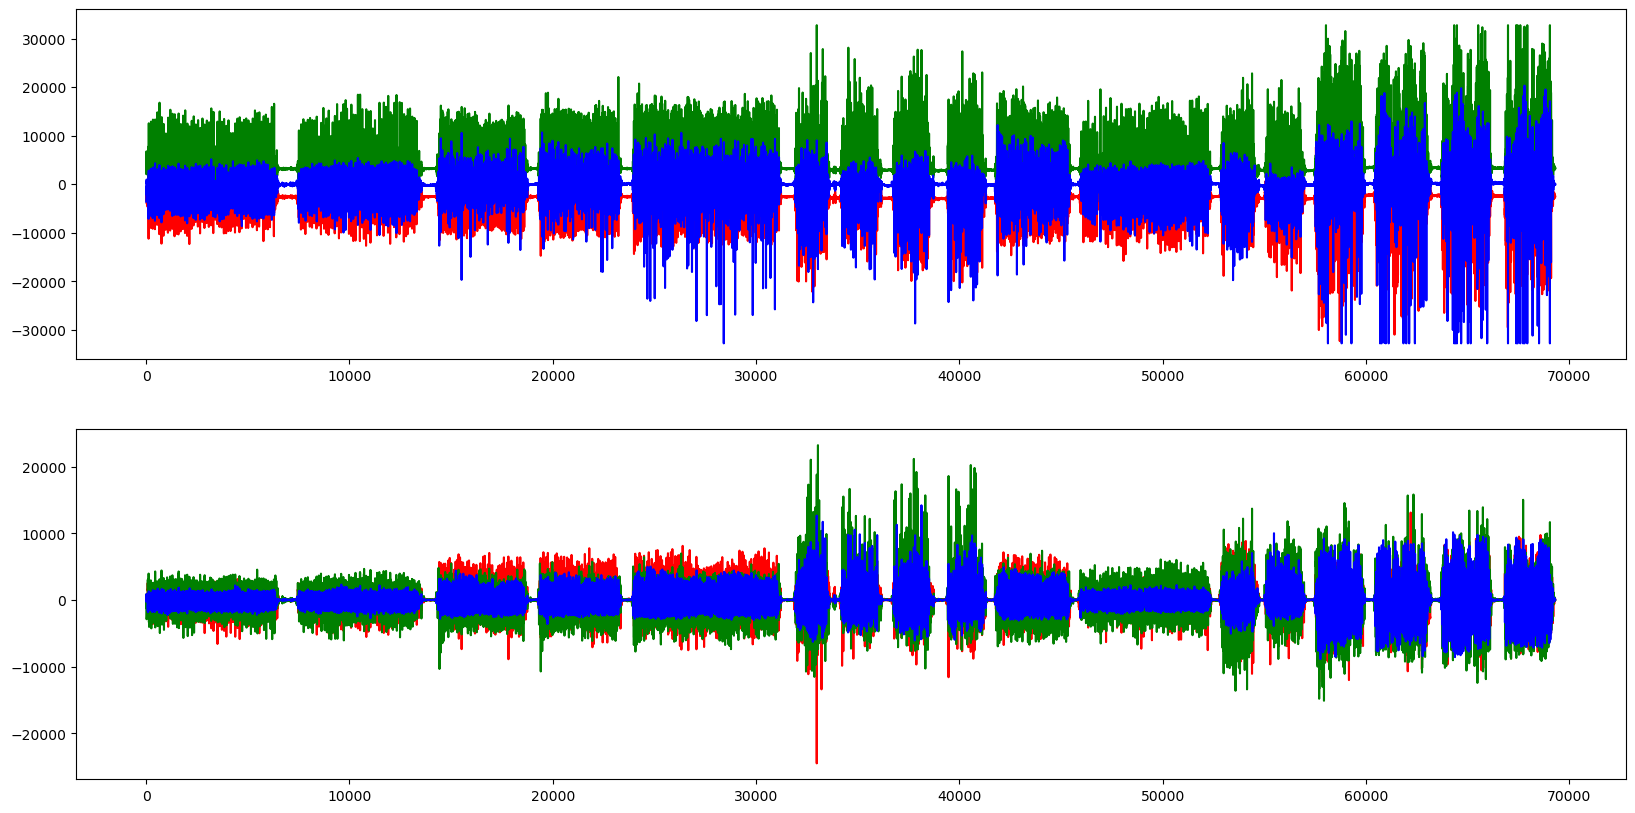

In [78]:
#Now we need to find the end point
start_ts = time_track[start_idx]
print(f"Start Time Stamp: {start_ts}")

# The video has been cut to 711 seconds in length - need to find 
# Start_ts + video_length seconds. This should land us at the end point
# We can sanity check this by inspecting the plot

end_idx = time_track.index(start_ts + video_length)

# Sanity Check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

In [79]:
# Read activity annatations CSV file

with open(activity_annotations_data_file, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader:
        time_Stamp = (row[0].split('='))[1]
        activity_set.append([float(time_Stamp),row[-1], map_activity(row[-1])])

print(activity_set)


[[0.0, 'Walking', 1], [66.2, 'Standing', 0], [75.4, 'Walking', 1], [139.333333, 'Standing', 0], [146.733333, 'Jogging', 2], [191.4, 'Standing', 0], [197.2, 'Jogging', 2], [239.466667, 'Standing', 0], [244.6, 'Jogging', 2], [320.933333, 'Standing', 0], [328.0, 'Side-Step', 3], [345.066667, 'Standing', 0], [351.533333, 'Side-Step', 3], [371.333333, 'Standing', 0], [376.733333, 'Side-Step', 3], [396.533333, 'Standing', 0], [403.533333, 'Side-Step', 3], [422.4, 'Standing', 0], [426.933333, 'Jogging', 2], [466.866667, 'Standing', 0], [471.066667, 'Walking', 1], [538.133333, 'Standing', 0], [542.333333, 'Side-Step', 3], [561.066667, 'Standing', 0], [565.066667, 'Side-Step', 3], [584.866667, 'Standing', 0], [589.6, 'Running', 4], [614.8, 'Standing', 0], [619.8, 'Running', 4], [648.333333, 'Standing', 0], [653.533333, 'Running', 4], [678.466667, 'Standing', 0], [684.466667, 'Running', 4], [710.666667, 'Standing', 0]]


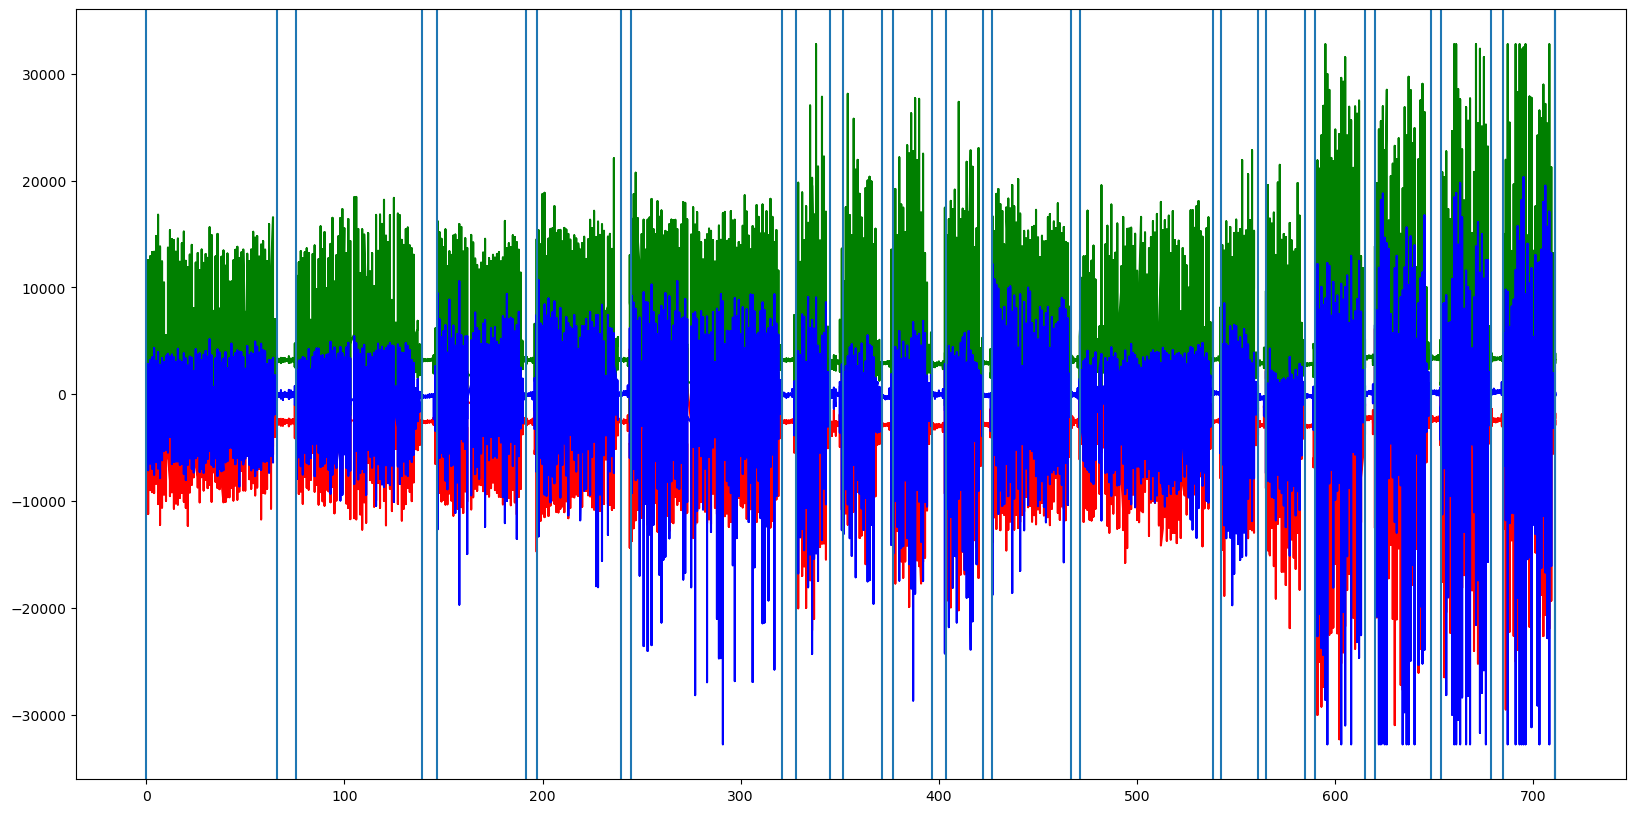

In [81]:
# Now we can create an activity time track for each data point within
# the imu timeseries. We will have a list to store the numeric code and the string.
activity_timeseries = []
activity_string_timeseries = []
activity_idx = 0

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

#Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to nex activity
        activity_idx = activity_idx + 1
        next_activity_ts = activity_set[activity_idx+1][0]
    
    
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))



Text(0.5, 1.0, 'Activity Distribution')

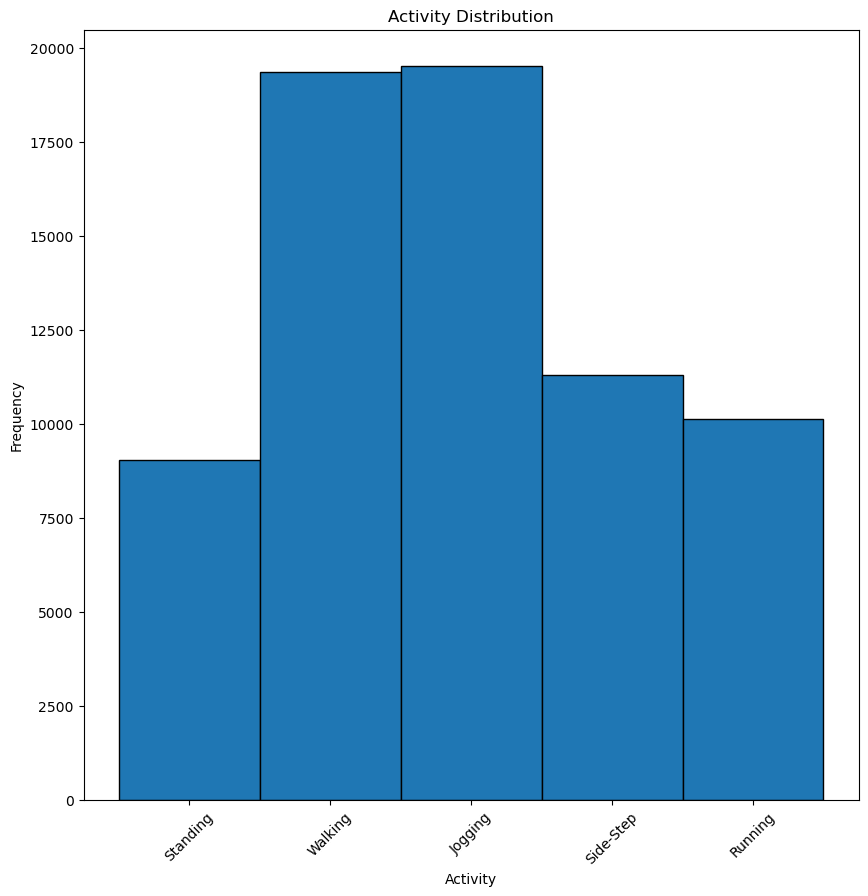

In [93]:
fig, ax = plt.subplots(figsize=(10,10))
counts, bins, patches = ax.hist(
    activity_timeseries, 
    bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], 
    edgecolor='black')

# Label the bins with activity names
ax.set_xticks([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
ax.set_xticklabels(get_activity_list(), rotation=45)

# Add axis labels and title
ax.set_xlabel("Activity")
ax.set_ylabel("Frequency")
ax.set_title("Activity Distribution")

In [94]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

In [102]:
# Now we can start working on the machine learning workflow.
# The first step is to calculate some feature that we can use.
# We will base our analysis around a moving window across the
# the timeseries data. This involves taking a fixed length window, based upon the time, and
# sliding it across the data.
# To keep thing simple, we will start with a 1 second window with no overlapping
# data points

feature_set = []
target_set  = []            
window_size = 1.0;            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    if t not in time_track_segment or t+window_size not in time_track_segment:
        continue
    
    #The index function finds the index of the first occurnace of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq
    
    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)



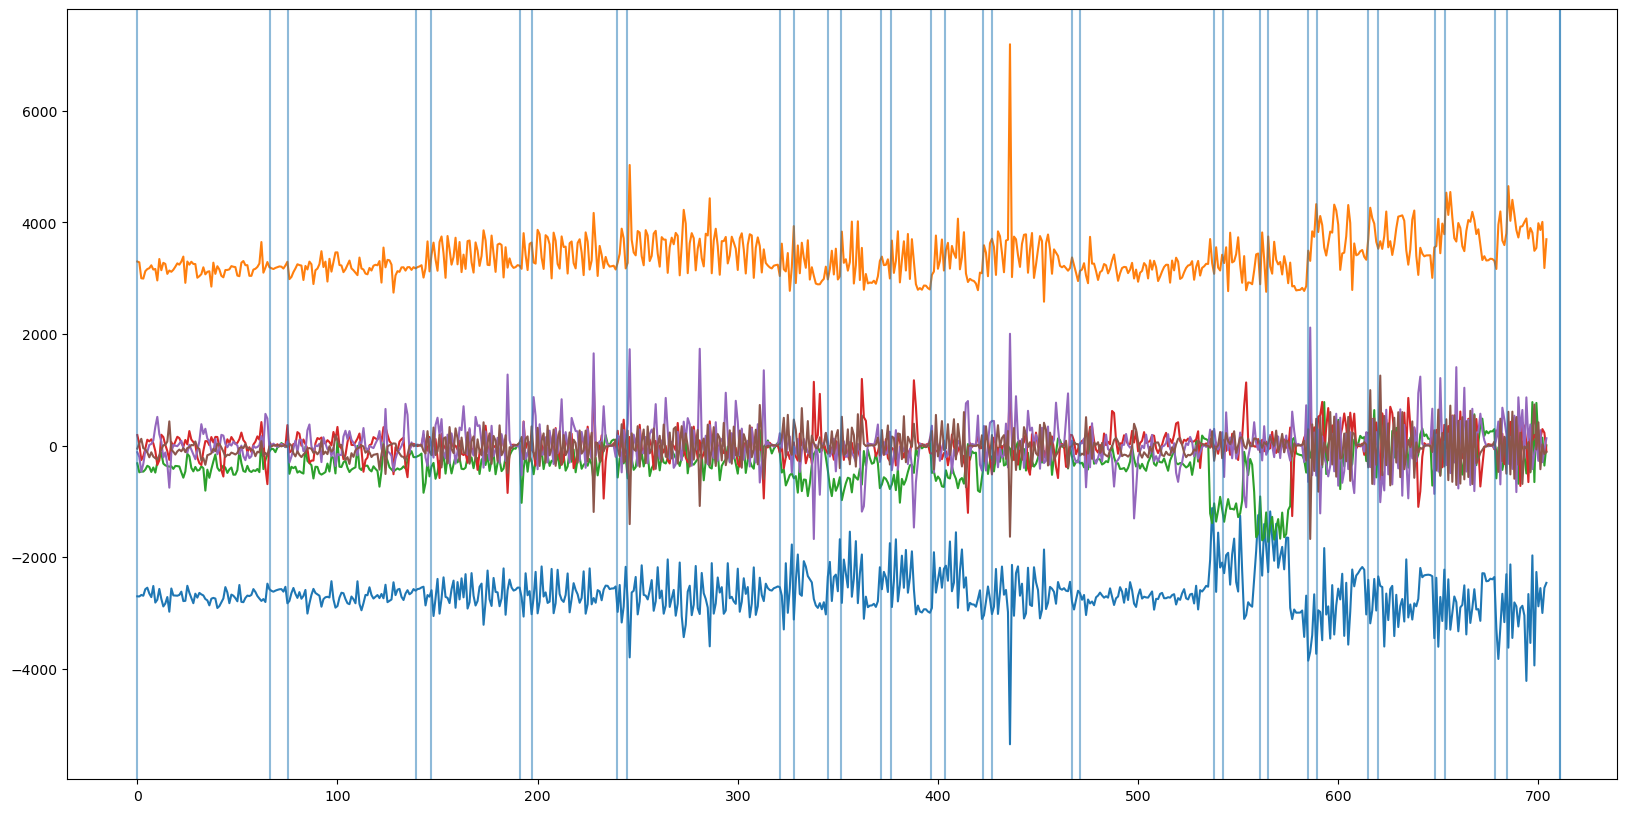

In [114]:
# Separate the mean values for accelerometer and gyroscope
mu_ax_values = [row[0] for row in feature_set]
mu_ay_values = [row[1] for row in feature_set]
mu_az_values = [row[2] for row in feature_set]
mu_gx_values = [row[3] for row in feature_set]
mu_gy_values = [row[4] for row in feature_set]
mu_gz_values = [row[5] for row in feature_set]

# Create time array
time_values = range(len(feature_set))

fig, ax = plt.subplots(figsize=(20,10))

# Plot the accelerometer mean values
ax.plot(time_values, mu_ax_values, label='mu_ax')
ax.plot(time_values, mu_ay_values, label='mu_ay')
ax.plot(time_values, mu_az_values, label='mu_az')


# Plot the gyroscope mean values
ax.plot(time_values, mu_gx_values, label='mu_gx')
ax.plot(time_values, mu_gy_values, label='mu_gy')
ax.plot(time_values, mu_gz_values, label='mu_gz')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)

In [115]:
# Lets visualise some of the features just out of interest - we will look at the SMA and AI

# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(range(1,10),np.array(feature_set)[:,1], color='r')
# ax.plot(range(1,10),np.array(feature_set)[:,2], color='g')
# ax.plot(range(1,10),np.array(feature_set)[:,3], color='b')
# ax.plot(range(1,10),np.array(feature_set)[:,4], color='c')

# # Plot the location of the activity transitions just to sanity check the data
# for act in np.array(list(zip(*activity_set)))[0,:]:
#     ax.axvline(float(act), alpha=0.5)

CV Train Recall: [0.81690141 0.94482759 0.87671233 0.86904762 0.84146341]
CV Train Precision: [0.81690141 0.92567568 0.93430657 0.73737374 0.94520548]
CV Train F1 Score: [0.81690141 0.93515358 0.90459364 0.79781421 0.89032258]
Test Recall: [0.95       0.92156863 0.9245283  0.63333333 0.86956522]
Test Precision: [0.79166667 0.87037037 0.875      0.9047619  0.90909091]
Test F1 Score: [0.86363636 0.8952381  0.89908257 0.74509804 0.88888889]


/Users/lucasfonsecamartins/anaconda3/envs/COSC102/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/lucasfonsecamartins/anaconda3/envs/COSC102/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


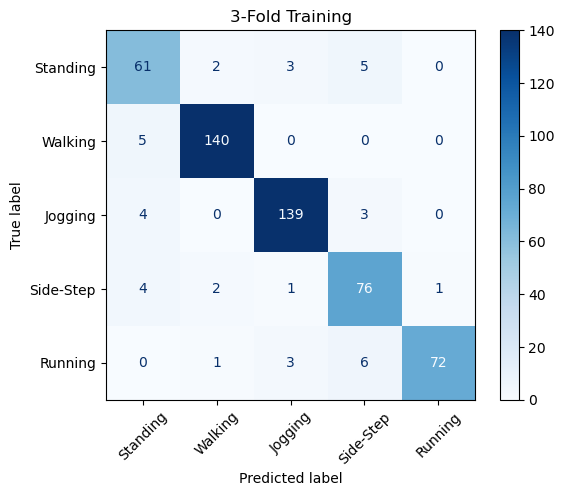

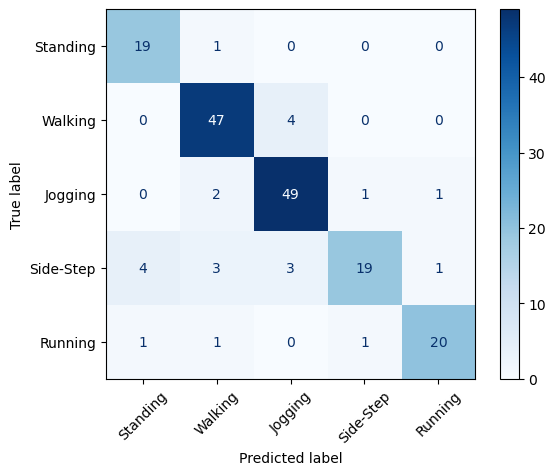

: 

In [121]:
from sklearn import neighbors
# Now we can apply a classifier - we will use a simple Decision Tree classifier for this demo.            
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)
# Set the number neightbours to use in the classifier
#n_neighbors = 10
# we create an instance of Neighbours Classifier and fit the data.
#clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

# Train
clf = DecisionTreeClassifier(max_depth=3)

clf.fit(X_train, y_train)
# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# Print out the recall, precision and F1 scores
# There will be a value for each class
# CV Train
print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_train, y_train,
                                 display_labels=get_activity_list(),
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title('3-Fold Training')

fig, ax = plt.subplots()
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=get_activity_list(),
                                 cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(45)